# Notebook to compare Model Results in R17 Maritime, UCLA vs UA 

# Step 0 - Prepare Notebook

In [1]:
import os
import time 
import json
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from snowML.datapipe.utils import data_utils as du
from snowML.LSTM import set_hyperparams as sh
from snowML.LSTM import LSTM_pre_process as pp 
from snowML.LSTM import LSTM_train as LSTM_tr
from snowML.LSTM import LSTM_metrics as met
from snowML.LSTM import LSTM_plot3 as plot3
from snowML.Scripts import local_training_mixed_loss as ml


# Step 1 - Define HyperParams and Test Hucs 

In [2]:
# get list of hucs 
f = "../../src/snowML/datapipe/huc_lists/MandM_hucs_.json"
with open(f, 'r', encoding='utf-8') as file:
    data = json.load(file)
hucs_mar = data["maritime_hucs"]
print(f"Number of hcs_mar is {len(hucs_mar)}")


Number of hcs_mar is 154


In [3]:
# error ls 
error_ls = ['170300010105',
  '171100060102',
  '170200110203',
  '171100060106',
  '170200090107',
  '171100090201',
  '171100060204',
  '171100050803',
  '170200110201', 
  '171100080201',
  '170300020304',
  '171100050603',
  '171100080204',
  '171100060103',
  '170200090204',
  '171100090203',
  '170200090106',
  '171100060302',
  '171100050602']
len(error_ls)

19

In [4]:
hucs_mar_clean = [huc for huc in hucs_mar if huc not in error_ls]
len(hucs_mar_clean)

135

In [5]:
# set hyperparams
# load base line params 
params = sh.create_hyper_dict()
# reset the ones we care about
params["learning_rate"] = .001
params["n_epochs"] = 5   # NOTE ONLY 5 EPOCHS!! 
params["batch_size"] = 32
params["var_list"] = ['mean_pr', 'mean_tair']
params["expirement_name"] = "UA_UCLA_Compare"
params["loss_type"] = "mse"
params["train_size_dimension"] = "time"
params["train_size_fraction"] = .67
params["recursive_rredict"] = False 
params["UCLA"] = False # start w/ UA data then update 
#params

# Step 2 - Define model functions 

In [6]:
def pre_process(huc, params): 
    # normalize the data and create train/test split 
    df_dict = pp.pre_process_separate([huc], params["var_list"], UCLA = params["UCLA"], filter_dates=params["filter_dates"])
    train_size_frac = params["train_size_fraction"]
    df = df_dict[huc]
    df_train, _, _, _ = pp.train_test_split_time(df, train_size_frac)
    return df_dict, df_train

def train_model (df_train, params): 
    model_dawgs, optimizer_dawgs, loss_fn_dawgs = ml.initialize_model(params)
   
    for epoch in range(params["n_epochs"]):
        # for local training, call fine_tune instead of pre_train
        #print(f"Training in epoch {epoch}")
        LSTM_tr.fine_tune(
            model_dawgs,
            optimizer_dawgs,
            loss_fn_dawgs,
            df_train,
            params,
            epoch
            )
    return model_dawgs 

def evaluate(model_dawgs_trained, df_dict, huc, params):
    if params["UCLA"]:
        suffix = "UCLA"
    else: 
        suffix = "UA"
    data, y_tr_pred, y_te_pred, y_tr_true, y_te_true,  y_te_pred_recur, train_size, = LSTM_tr.predict_prep (model_dawgs_trained,
                df_dict, huc, params)
    metric_dict_test = met.calc_metrics(y_te_true, y_te_pred, metric_type = f"test_{suffix}")
    if y_te_pred_recur is not None:
        metric_dict_test_recur = met.calc_metrics(y_te_true, y_te_pred_recur, metric_type = f"test_recur_{suffix}")
        combined_dict = {**metric_dict_test, **metric_dict_test_recur}
    else:
        combined_dict = metric_dict_test
        
    return combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size


def combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, train_size, params):
    results_df = data[["mean_swe"]].copy()
    results_df["y_tr_pred"] = list(y_tr_pred) + [float('nan')] * (len(results_df) - len(y_tr_pred))
    results_df["y_te_pred"] = [float('nan')] * (train_size+params["lookback"]) + list(y_te_pred)
    results_df["y_tr_true"] = list(y_tr_true) + [float('nan')] * (len(results_df) - len(y_tr_true))
    results_df["y_te_true"] = [float('nan')] *(train_size+params["lookback"]) + list(y_te_true)
    return results_df

def label_results(df, suffix):
    df = df.add_suffix(f"_{suffix}")
    return df

def run_one_data_type (huc, params, data_type = "UA"): 
    if data_type == "UCLA": 
        params["UCLA"] = True 
        suffix = "UCLA" 
    else: 
        params["UCLA"] = False
        suffix = "UA"
    df_dict, df_train = pre_process(huc, params)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # ignore warning about drop param being irrelevant with single deep layer
        model_dawgs_trained = train_model(df_train, params)
    combined_dict, data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size = evaluate(model_dawgs_trained, df_dict, huc, params)
    df_results = combine_results(data, y_tr_pred, y_te_pred, y_tr_true, y_te_true, y_te_pred_recur, tr_size, params)
    df_results = label_results(df_results, suffix)
    return combined_dict, df_results, tr_size

def run_all(hucs, params, dis = False): 
    time_start = time.time()
    dict_UA, results_df_UA, tr_size_UA  = run_one_data_type(huc, params)
    dict_UCLA, results_df_UCLA, tr_size_UCLA = run_one_data_type (huc, params, data_type = "UCLA")
    metrics_dict_all = {**dict_UA, **dict_UCLA}
    results_df_all = pd.concat([results_df_UA, results_df_UCLA], axis=1)
    plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size_UA, huc, params, dis = dis)
    du.elapsed(time_start)
    return metrics_dict_all, results_df_all
       

def plot_all(metrics_dict_all, dict_UA, dict_UCLA, results_df_all, tr_size, huc, params, dis = False):
    cutoff = tr_size + params["lookback"]
    df_plot = results_df_all.iloc[cutoff:]

    # Prepare data for plots
    plot_dict_UA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UA"], "blue", "SWE Estimates UA Data (Physics Based Model)", n_offset=0)
    plot_dict_UA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UA"], "green", "SWE Predictions UA Data", n_offset=0)

    plot_dict_UCLA_true = plot3.assemble_plot_dict(df_plot["mean_swe_UCLA"], "black", "SWE Estimates UCLA Data (Physics Based Model)", n_offset=0)
    plot_dict_UCLA_pred = plot3.assemble_plot_dict(df_plot["y_te_pred_UCLA"], "red", "SWE Predictions UCLA Data", n_offset=0)

    x_axis_vals = df_plot.index
    ttl = f"SWE_Actual_vs_Predicted_for_huc_{huc}"

    # Temp file paths
    filenames = [f"plot_{i}.png" for i in range(3)]

    # Plot and save each figure
    plot3.plot3b(x_axis_vals, [plot_dict_UA_true, plot_dict_UA_pred], ttl + "_UA_data", metrics_dict=dict_UA)
    plt.savefig(filenames[0])
    plt.close()

    plot3.plot3b(x_axis_vals, [plot_dict_UCLA_true, plot_dict_UCLA_pred], ttl + "_UCLA_data", metrics_dict=dict_UCLA)
    plt.savefig(filenames[1])
    plt.close()

    plot3.plot3b(x_axis_vals,
                 [plot_dict_UA_true, plot_dict_UA_pred, plot_dict_UCLA_true, plot_dict_UCLA_pred],
                 ttl, metrics_dict=metrics_dict_all)
    plt.savefig(filenames[2])
    plt.close()

    # Combine saved plots vertically
    images = [Image.open(fname) for fname in filenames]
    widths, heights = zip(*(img.size for img in images))

    total_height = sum(heights)
    max_width = max(widths)
    combined_img = Image.new('RGB', (max_width, total_height))

    y_offset = 0
    for img in images:
        combined_img.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the final combined image
    output_path = f"charts/SWE_combined_plots_{huc}.png"
    combined_img.save(output_path)
    if dis: 
        display(combined_img)
    
    # Cleanup temporary files
    for fname in filenames:
        os.remove(fname)

    print(f"Saved combined plot to {output_path}")


# Step 3 - Get Results Sample Huc 

In [22]:
huc = 171100050606

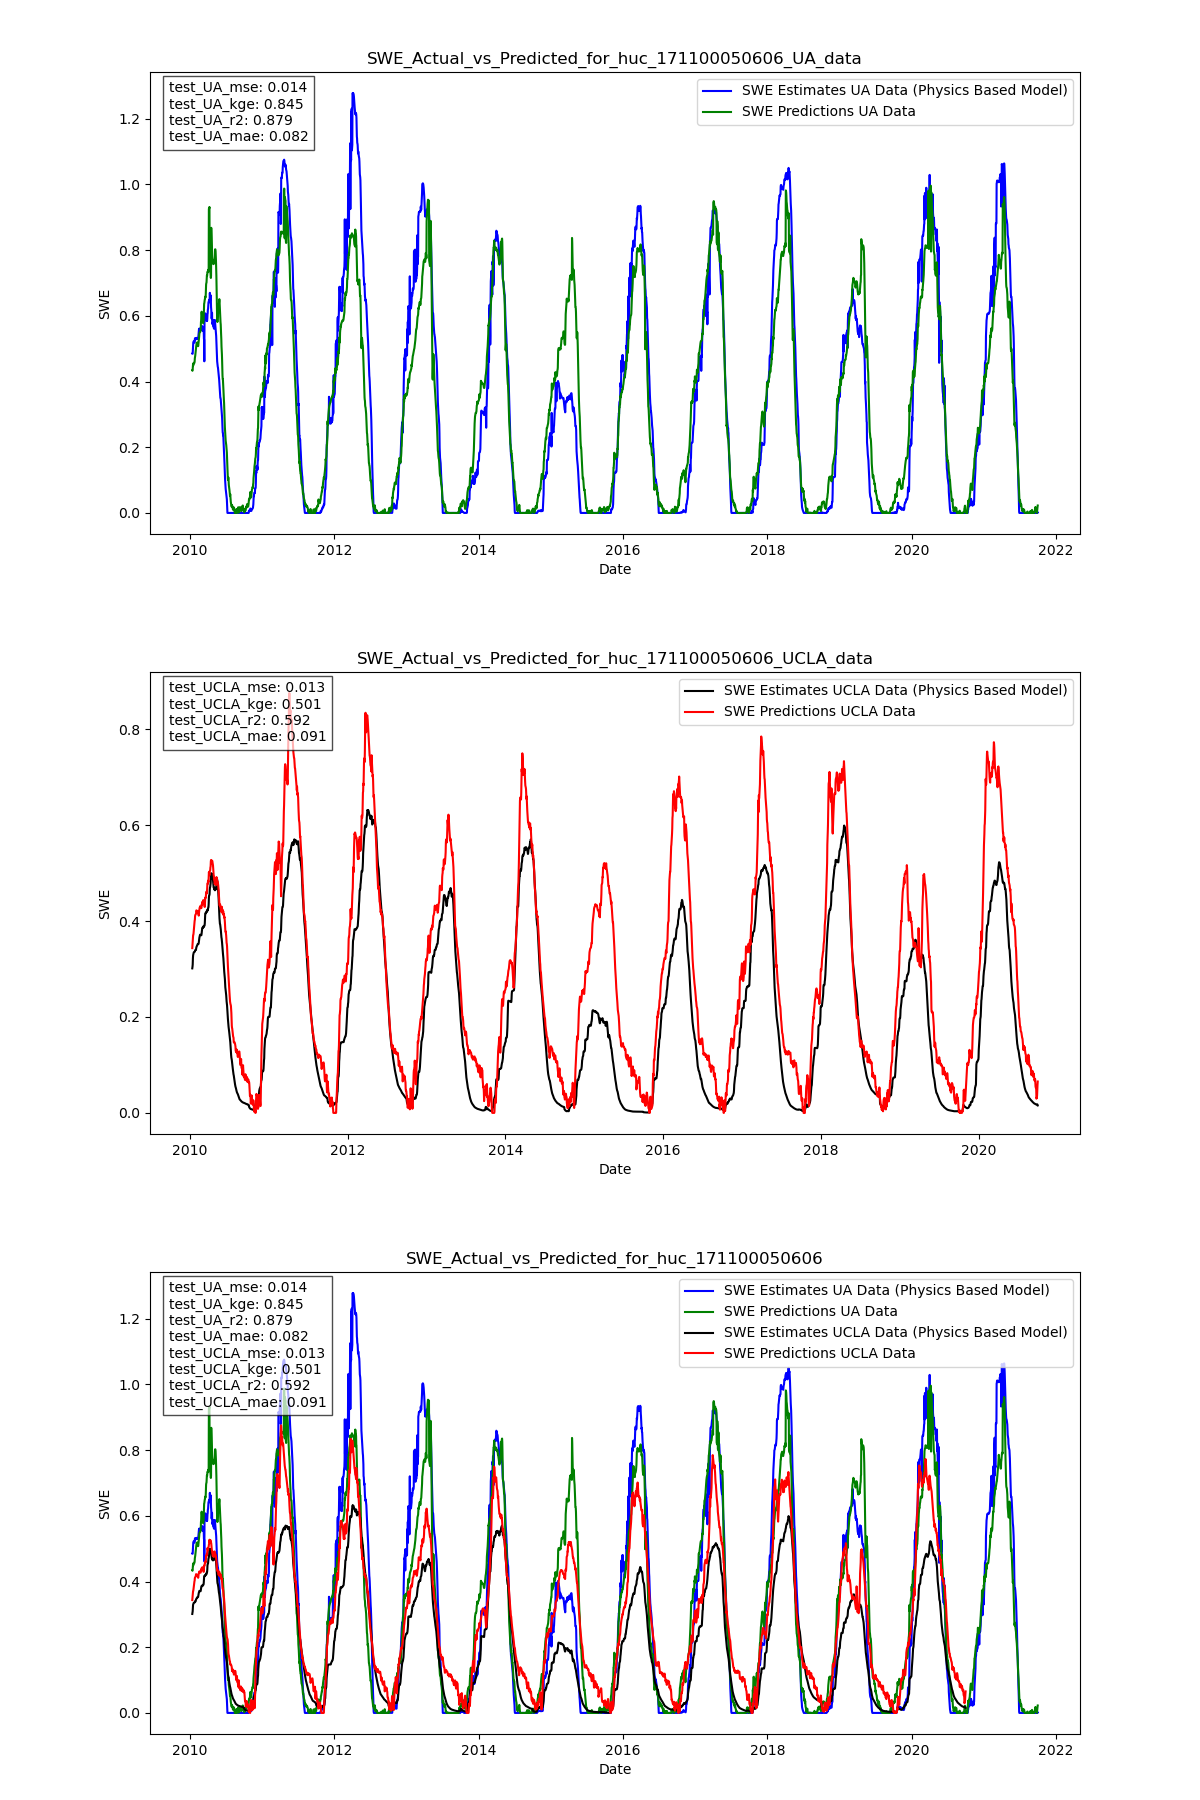

Saved combined plot to charts/SWE_combined_plots_171100050606.png
______Elapsed time is 44 seconds


In [23]:
dict, df = run_all(huc, params, dis = True)

In [9]:
dict

{'test_UA_mse': 0.06840401,
 'test_UA_kge': 0.457876336196835,
 'test_UA_r2': 0.4253090348682993,
 'test_UA_mae': 0.19069861,
 'test_UCLA_mse': 0.016690591,
 'test_UCLA_kge': 0.4590094672151467,
 'test_UCLA_r2': 0.4873910523685867,
 'test_UCLA_mae': 0.08599685}

In [10]:
df

,mean_swe_UA,y_tr_pred_UA,y_te_pred_UA,y_tr_true_UA,y_te_true_UA,mean_swe_UCLA,y_tr_pred_UCLA,y_te_pred_UCLA,y_tr_true_UCLA,y_te_true_UCLA
day,,,,,,,,,,
1984-10-01,0.000000,[0.4426859],NaN,[0.9314286],NaN,0.000000,[0.48828095],NaN,[0.54418176],NaN
1984-10-02,0.000000,[0.36443764],NaN,[0.565],NaN,0.000000,[0.4902128],NaN,[0.5512264],NaN
1984-10-03,0.000000,[0.39213693],NaN,[0.871],NaN,0.000000,[0.48864996],NaN,[0.5540232],NaN
1984-10-04,0.000000,[0.43772283],NaN,[0.9045714],NaN,0.000000,[0.49069375],NaN,[0.55521774],NaN
1984-10-05,0.000000,[0.44105226],NaN,[0.9431429],NaN,0.000036,[0.49546808],NaN,[0.55822414],NaN
...,...,...,...,...,...,...,...,...,...,...
2021-09-26,0.000000,NaN,[0.06510692],NaN,[0.0],NaN,NaN,NaN,NaN,NaN
2021-09-27,0.000000,NaN,[0.054634564],NaN,[0.0],NaN,NaN,NaN,NaN,NaN
2021-09-28,0.000000,NaN,[0.069577396],NaN,[0.0],NaN,NaN,NaN,NaN,NaN


# Step 4 Look through all the maritime hucs

In [11]:
df_results = pd.DataFrame(columns=['test_UA_mse', 'test_UA_kge', 'test_UA_r2', 'test_UA_mae', 'test_UCLA_mse', 'test_UCLA_kge', 'test_UCLA_r2'])

for huc in hucs_mar_clean[0:2]:    
    dict, df = run_all(huc, params)
    f_out = f"model_results_UA_UCLA_huc_{huc}"
    new_row = pd.DataFrame([dict])
    df_results = pd.concat([df_results, new_row], ignore_index=True)

    
df_results


Saved combined plot to charts/SWE_combined_plots_170200090101.png
______Elapsed time is 57 seconds
{'test_UA_mse': 0.018258791, 'test_UA_kge': 0.9384708254896783, 'test_UA_r2': 0.8934198530869106, 'test_UA_mae': 0.09297909, 'test_UCLA_mse': 0.021621956, 'test_UCLA_kge': 0.64642708830366, 'test_UCLA_r2': 0.6672342984234332, 'test_UCLA_mae': 0.09915662}
<bound method NDFrame.head of             mean_swe_UA y_tr_pred_UA   y_te_pred_UA y_tr_true_UA y_te_true_UA  \
day                                                                             
1984-10-01       0.0050  [1.1439224]            NaN      [0.876]          NaN   
1984-10-02       0.0010  [1.1633922]            NaN  [0.9036667]          NaN   
1984-10-03       0.0000  [1.1539565]            NaN  [0.9401667]          NaN   
1984-10-04       0.0000  [1.1529593]            NaN  [0.9458333]          NaN   
1984-10-05       0.0000  [1.1509728]            NaN      [0.966]          NaN   
...                 ...          ...            .

KeyboardInterrupt: 

In [ ]:
# with mlflow.start_run():
        #ml.set_ml_server(params)
        # log all the params
        #mlflow.log_params(params)
        # log the hucs & train size fraction
        #mlflow.log_param("hucs", hucs)
        # log the model
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}", pickle_module=cloudpickle)
        #mlflow.pytorch.log_model(model_dawgs, artifact_path=f"model_{huc}")
            